#Загрузка модулей


In [0]:
!pip install python-telegram-bot --upgrade

Requirement already up-to-date: python-telegram-bot in /usr/local/lib/python3.6/dist-packages (12.3.0)


In [0]:
!pip install -U ipykernel

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.6/dist-packages (5.1.4)


In [0]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

#Загрузка библиотек


In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

#Перенос стиля

In [0]:
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

##Доп. функции и классы

In [0]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

#plt.figure()
#imshow(style_img, title='Style Image')

#plt.figure()
#imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

##Загрузка модели

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

##Функции для переноса стиля

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [0]:
def imsave(tensor, title="out.jpg"):
    image = tensor.cpu().clone()
    image = image.squeeze(0)      # функция для сохранения изображения
    image = unloader(image)
    image.save(title+".jpg", "JPEG", quality=100, optimize=True, progressive=True)

##Перенос стиля
 

In [0]:
def run_style_transfer(update, cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 100 == 0:
                    '''plt.figure()
                    imshow(input_img, title='Output Image')
                    plt.ioff()
                    plt.show()    '''

                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()
                    if run[0] == 100: update.message.reply_text('Please wait...100 of 500 itearations are done')
                    if run[0] == 200: update.message.reply_text('I am still working...200 of 500 itearations are done')
                    if run[0] == 300: update.message.reply_text('Wait a liitle bit...300 of 500 itearations are done')
                    if run[0] == 400: update.message.reply_text('The end is close...400 of 500 itearations are done')
                    
                    logger.info("Running")

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

#Бот


2020-02-05 06:22:39,848 - __main__ - INFO - Images uploaded
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Building the style transfer model..
Optimizing..


2020-02-05 06:23:14,018 - __main__ - INFO - Running


run [100]:
Style Loss : 4.775281 Content Loss: 13.682995



2020-02-05 06:23:47,300 - __main__ - INFO - Running


run [200]:
Style Loss : 2.591455 Content Loss: 12.163542



2020-02-05 06:24:21,883 - __main__ - INFO - Running


run [300]:
Style Loss : 2.208464 Content Loss: 11.653212



2020-02-05 06:24:55,051 - __main__ - INFO - Running


run [400]:
Style Loss : 2.084278 Content Loss: 11.445030



2020-02-05 06:25:28,309 - __main__ - INFO - Running


run [500]:
Style Loss : 2.025434 Content Loss: 11.340652



2020-02-05 06:25:34,805 - __main__ - INFO - Style transfer complete


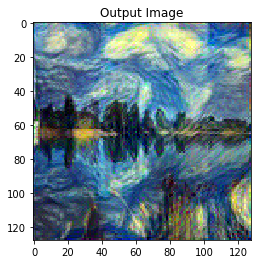

2020-02-05 06:26:04,151 - telegram.ext.updater - INFO - Received signal 2 (SIGINT), stopping...
2020-02-05 06:26:08,757 - telegram.ext.updater - WARNING - Exiting immediately!


In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# This program is dedicated to the public domain under the CC0 license.

"""
First, a few callback functions are defined. Then, those functions are passed to
the Dispatcher and registered at their respective places.
Then, the bot is started and runs until we press Ctrl-C on the command line.
Usage:
Example of a bot-user conversation using ConversationHandler.
Send /start to initiate the conversation.
Press Ctrl-C on the command line or send a signal to the process to stop the
bot.
"""

import logging

from telegram import (ReplyKeyboardMarkup, ReplyKeyboardRemove)
from telegram.ext import (Updater, CommandHandler, MessageHandler, Filters,
                          ConversationHandler)

# Enable logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

CONTENT, STYLE, PROCESS = range(3)


def start(update, context):
    
    update.message.reply_text(
        'Hi! My name is Artistic Bot. I will darw a picrure for you'
        'Send /cancel to stop talking to me.\n\n'
        'Send me content image')
    return CONTENT


def content(update, context):
    user = update.message.from_user
    photo_file = update.message.photo[-1].get_file()
    photo_file.download('content.jpg')
    #logger.info("Photo of %s: %s", user.first_name, 'user_photo.jpg')
    update.message.reply_text('Now please send me your style image')

    return STYLE

def style(update, context):
    user = update.message.from_user
    photo_file = update.message.photo[-1].get_file()
    photo_file.download('style.jpg')
    #logger.info("Photo of %s: %s", user.first_name, 'user_photo.jpg')
    update.message.reply_text('Thank you! Begin to process images. Wait for a couple of minutes.')

    style_img = image_loader("/content/style.jpg")# as well as here
    content_img = image_loader("/content/content.jpg")#измените путь на тот который у вас.
    logger.info("Images uploaded")

    input_img = content_img.clone()
    # if you want to use white noise instead uncomment the below line:
    # input_img = torch.randn(content_img.data.size(), device=device)

    # add the original input image to the figure:
    #plt.figure()
    #imshow(input_img, title='Input Image')
    output = run_style_transfer(update, cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img)
    logger.info("Style transfer complete")

    plt.figure()
    imshow(output, title='Output Image')
    imsave(output, '/content/output')
    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

    context.bot.send_photo(chat_id=update.effective_chat.id, photo=open('/content/output.jpg', 'rb'))

    return PROCESS


def process(update, context):
    
    return ConversationHandler.END


def cancel(update, context):
    user = update.message.from_user
    logger.info("User %s canceled the conversation.", user.first_name)
    update.message.reply_text('Bye! I hope we can talk again some day.',
                              reply_markup=ReplyKeyboardRemove())

    return ConversationHandler.END


def error(update, context):
    """Log Errors caused by Updates."""
    logger.warning('Update "%s" caused error "%s"', update, context.error)


def main():
    # Create the Updater and pass it your bot's token.
    # Make sure to set use_context=True to use the new context based callbacks
    # Post version 12 this will no longer be necessary
    updater = Updater("1084285882:AAG9-7MTQSOd2V8VEZ0wIyf6PJu-fzNNQCw", use_context=True)

    # Get the dispatcher to register handlers
    dp = updater.dispatcher

    
    # Add conversation handler with the states GENDER, PHOTO, LOCATION and BIO
    conv_handler = ConversationHandler(
        entry_points=[CommandHandler('start', start)],

        states={
            CONTENT: [MessageHandler(Filters.photo, content)],

            STYLE: [MessageHandler(Filters.photo, style)],

            PROCESS: [MessageHandler(Filters.text, process)]
            
            #LOCATION: [MessageHandler(Filters.location, location),
             #          CommandHandler('skip', skip_location)],

            #BIO: [MessageHandler(Filters.text, bio2)]
        },

        fallbacks=[CommandHandler('cancel', cancel)]
    )

    dp.add_handler(conv_handler)

    # log all errors
    dp.add_error_handler(error)

    # Start the Bot
    updater.start_polling()

    # Run the bot until you press Ctrl-C or the process receives SIGINT,
    # SIGTERM or SIGABRT. This should be used most of the time, since
    # start_polling() is non-blocking and will stop the bot gracefully.
    updater.idle()


if __name__ == '__main__':
    main()